In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_validate

## 데이터 수집하기

In [2]:
foreign= pd.read_csv("3년선물.csv",encoding="euc-kr")
interest =pd.read_excel("interest_rate.xlsx")
mbs = pd.read_excel("K-MBS.xlsx")

In [3]:
mbs.drop(["번호","발행회차"],axis=1, inplace= True)

In [4]:
mbs.drop(0, inplace= True)

In [33]:
from datetime import datetime
dates = []
for d in mbs.발행일자:
    d.strftime("%Y/%m/%d")

AttributeError: 'str' object has no attribute 'strftime'

In [3]:
interest= interest.T.drop(["통계표","단위","자료구분"])

In [4]:
foreign = foreign[["년/월/일","외국인"]]
foreign.head()

,년/월/일,외국인
0,2019/01/02,"1,359"
1,2019/01/03,944
2,2019/01/04,"3,128"
3,2019/01/07,"1,652"
4,2019/01/08,"1,613"


In [5]:
interest.columns = interest.iloc[0,:]

In [6]:
interest["년/월/일"]= interest.index 

In [7]:
feature = pd.merge(foreign, interest, on = "년/월/일", how='left')

In [8]:
feature

,년/월/일,외국인,국고채(3년),국고채(5년),한국은행 기준금리
0,2019/01/02,"1,359",1.802,1.873,1.75
1,2019/01/03,944,1.796,1.869,1.75
2,2019/01/04,"3,128",1.797,1.866,1.75
3,2019/01/07,"1,652",1.807,1.877,1.75
4,2019/01/08,"1,613",1.81,1.892,1.75
...,...,...,...,...,...
571,2021/04/26,"3,156",1.119,1.602,0.5
572,2021/04/27,"6,699",1.097,1.584,0.5
573,2021/04/28,"-9,571",1.105,1.604,0.5
574,2021/04/29,-907,1.121,1.601,0.5


In [9]:
feature.isna().sum()

년/월/일        0
외국인          0
국고채(3년)      0
국고채(5년)      0
한국은행 기준금리    0
dtype: int64

In [10]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 576 entries, 0 to 575
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   년/월/일      576 non-null    object
 1   외국인        576 non-null    object
 2   국고채(3년)    576 non-null    object
 3   국고채(5년)    576 non-null    object
 4   한국은행 기준금리  576 non-null    object
dtypes: object(5)
memory usage: 27.0+ KB


## 수치화

In [11]:
number = []
for i in range(len(feature)):
    comma = feature.iloc[i,1].split(',')
    if len(comma)>1:
        num = comma[0]+comma[1]
        num = int(num)
        #print(num)
    else:
        num = int(comma[0])
    number.append(num)
feature.iloc[:,1] = number

In [12]:
feature.iloc[:,2:] = feature.iloc[:,2:].astype('float32')

## Scaling

In [13]:
from scipy.stats import skew
numeric_feats = feature.dtypes[feature.dtypes != "object"].index
skewed_feats =  feature[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats =skewed_feats.index


In [14]:
skewed_feats
## 치우쳐진 데이터는 없음

Index([], dtype='object')

In [15]:
scaled = []
mean = feature.외국인.mean()
std = feature.외국인.std()
for i in range(len(feature)):
    scaled_i = (i-mean)/std
    scaled.append(scaled_i)
feature.외국인 = scaled

In [16]:
feature.head()

,년/월/일,외국인,국고채(3년),국고채(5년),한국은행 기준금리
0,2019/01/02,0.015220,1.802,1.873,1.75
1,2019/01/03,0.015391,1.796,1.869,1.75
2,2019/01/04,0.015562,1.797,1.866,1.75
3,2019/01/07,0.015734,1.807,1.877,1.75
4,2019/01/08,0.015905,1.810,1.892,1.75


## Model

<AxesSubplot:>

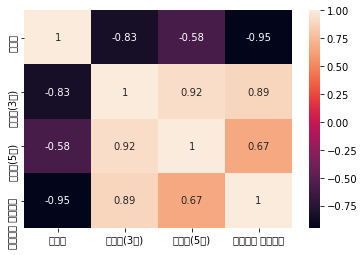

In [17]:
sns.heatmap(feature.corr(), annot= True, fmt ="0.2g")

In [27]:
X=  feature[["외국인","한국은행 기준금리"]]
y = feature["국고채(3년)"]

In [28]:
X_train , X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle = True,random_state=121)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

model1 = LinearRegression()
model1.fit(X_train,y_train)

pred = model1.predict(X_val)
mse = mean_squared_error(y_val, pred, squared = True) #MSE
rmse = mean_squared_error(y_val, pred, squared = False) #RMSE

print(f'MSE:{mse:.5f} RMSE {rmse:.5f}')


(460, 2) (116, 2) (460,) (116,)
MSE:0.02422 RMSE 0.15563


,외국인,한국은행 기준금리
0,0.015220,1.75
1,0.015391,1.75
2,0.015562,1.75
3,0.015734,1.75
4,0.015905,1.75
...,...,...
571,0.113003,0.50
572,0.113174,0.50
573,0.113345,0.50
574,0.113517,0.50
